In [1]:
%load_ext autoreload
%autoreload 2

## Graph transformers

Graph featurizers in `molfeat` are organized into pure tensor-based featurizers and  `dgl` backed graphs, both inheriting from `molfeat.trans.graph.GraphTransformer`.

Similar to molecular descriptors and fingerprints, there is a notion of the **atom and bond featurizers** which you can define to build you own custom graph featurizers. 

Some of the dgl featurizers are deeply integrated into the `dgl` and `dgllife` API allowing you to directly use your custom featurizers with them.

----
### AtomCalculator

Here we give an example of an atom featurizer. We will also build some custom properties to show how you can build you own.

Each atom featurizer takes as input an atom (assuming information on its environment are maintained) and returns its properties.

By default, two atom calculators are available.

In [2]:
import datamol as dm
from loguru import logger
from molfeat.calc.atom import AtomCalculator
from molfeat.calc.atom import AtomMaterialCalculator

Using backend: pytorch


For each of the featurizer, you have the option to concatenate them or keep them as a collection. More than often you will want to concatenate them, explaining the default behaviour. The major addition is thus from `molfeat.calc._atom_bond_features.atom_extended_properties`.

In [3]:
# do not concatenate ac
ac = AtomCalculator(concat=False)
# concatenate amc and set the merged feature name as 'material' instead of the default
amc = AtomMaterialCalculator(name="material")

`AtomMaterialCalculator` is mainly just a wrapper around the AtomCalculator that defines new atom featurizers, including precomputed atomic properties collected from material science packages.


In [4]:
data = dm.data.freesolv()

In [5]:
# len will always return the sum of all featurization
print(len(ac))
print(len(amc))

82
169


In [6]:
# you can still access to specific feature length
print(ac.feat_size("atom_one_hot"))

43


In [7]:
ac(data.smiles[0])

{'atom_one_hot': array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0

In [8]:
amc(data.smiles[0])

{'material': array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)}

**Defining some custom functions**

In [9]:
def is_transition_metal(
    atom,
):
    """Check whether an atom is a transition metal"""
    n = atom.GetAtomicNum()
    # we need to return an array
    return [(n >= 22 and n <= 29) or (n >= 40 and n <= 47) or (n >= 72 and n <= 79)]


my_feats = AtomCalculator.DEFAULT_FEATURIZER.copy()
my_feats["is_transition_metal"] = is_transition_metal
my_ac = AtomCalculator(featurizer_funcs=my_feats, name="custom_feat")
print("My atom feat is", len(my_ac), ", while default is ", len(ac))

My atom feat is 83 , while default is  82


In [10]:
my_ac(data.smiles.values[-1])

{'custom_feat': array([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

By default the input molecule is not ordered in any specific way, so if you want some canonical atom ranking, you would need to take care of that. This is handles by the `GraphTransformer` classes for you.

-----
### BondCalculator

Bond featurizer are similar in principle to the atom featurizers. They featurize bonds in a molecule. In `molfeat` we make the distinction between:

- `BondCalculator`: a pure bond featurizer that will only featurize bonds in the molecules (we assume a bigraph)
- `EdgeMatCalculator`: an edge featurizer that returns features between **all pairs of atoms**. For example you might want to define some distance based properties between pair of atoms.

In [11]:
from molfeat.calc.bond import BondCalculator

In [12]:
bc = BondCalculator(self_loop=False)
out = bc(data.smiles[0])
print(out)
print("Length", len(bc), "Featurized Mol size", out["he"].shape)

{'he': array([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 1, 1

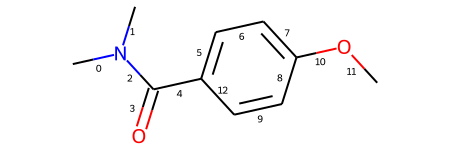

In [13]:
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.drawOptions.addBondIndices = True
mol = dm.to_mol(data.smiles[0])
mol

The above molecule has 13 bonds, explaining why we have 26 edges (bi-graph for each bond direction). 

In the example bellow, we have 39 edges features, because of adding self loops (as many as the 13 atoms). Then the concatenated features have one more columns that labels whether the edge is a self-loop or not.

In [14]:
bc2 = BondCalculator(self_loop=True)
out2 = bc2(data.smiles[0])
print(out2)
print("Length", len(bc2), "Featurized Mol size", out2["he"].shape)

{'he': array([[1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 1., 1., 1., 0., 0., 0., 

----
In the following, we will give an overview of the **EdgeMatCalculator**. This edge featurizer defines the same bond featurizer but has an additional pairwise distance function. 

**Due to its nature, all features need to be concatenated by default with this featurizer !**

In [15]:
from molfeat.calc.bond import EdgeMatCalculator

In [16]:
edge_feat = EdgeMatCalculator()
print(edge_feat.pairwise_atom_funcs)

{'pairwise_2D_dist': <function pairwise_2D_dist at 0x7fd83920a560>, 'pairwise_ring_membership': <function pairwise_ring_membership at 0x7fd83920a710>}


In [17]:
edge_feat(data.smiles[0])["he"].shape

(169, 17)

Let's replace the pairwise 2D distance by a 3D distance

In [18]:
from molfeat.calc._atom_bond_features import pairwise_3D_dist

my_edge_feat = dict(
    pairwise_ring_membership=edge_feat.pairwise_atom_funcs["pairwise_ring_membership"],
    pairwise_3D_dist=pairwise_3D_dist,
)
new_edge_feat = EdgeMatCalculator(pairwise_atom_funcs=my_edge_feat)
len(new_edge_feat)

17

In [19]:
# Expect this to fail
try:
    new_edge_feat(dm.to_mol(data.smiles[0]))
except ValueError as e:
    logger.error(e)

2021-07-16 17:23:59.835 | ERROR    | __main__:<module>:5 - Expected a molecule with conformers information.


In [20]:
mol = dm.to_mol(data.smiles[0])
mol = dm.conformers.generate(mol)

Let's ask for a tensor and also instead of a $({N_{atoms}}^2, Feats)$ features, let ask for a $(N_{atoms}, N_{atoms}, Feats)$ matrix


In [21]:
import torch

new_edge_feat(mol, dtype=torch.float, flat=False)["he"].shape

torch.Size([13, 13, 17])

---
### Putting all together with the Graph transformers
With the ability to define our own node and edge featurizers, we can defined any graph featurizer of interest. Strong defaults are made available in `molfeat`.


- `AdjGraphTransformer`:  adjacency tensor features that returns adjacency matrix as well as atom features and bond features when defined


- `CompleteGraphTransformer`:  featurizer that returns a complete graph (with or without self loops) matrix as well as atom features and bond features when defined


- `TopoDistGraphTransformer`:  topological distance based features that returns the pairwise path length matrix as graph matrix as well as atom features and bond features when defined.


- `DistGraphTransformer3D`:  real 3D distance-based features that returns the pairwise 3D distance matrix as graph matrix as well as atom features and bond features when defined. This featurizer requires molecules with conformers. Either precompute them, or use the appropriate callback function (`ConformerCallback`)


- `DGLGraphTransformer`: graph featurizer that returns a dgl graph. It's atom and bond featurizers are all compatible with the internal `dgllife` featurizer, however the class is made generic enough to work without `dgllife` allowing custom extension. 

**Important**: the tensor-based featurizers only supports the EdgeMatCalculator featurizer an no BondCalculator for quite obvious reasons.

In [22]:
from molfeat.trans.graph import AdjGraphTransformer
from molfeat.trans.graph import DistGraphTransformer3D
from molfeat.trans.graph import DGLGraphTransformer

In [23]:
# atom featurizer when not provided will fallback to the default
adj_trans = AdjGraphTransformer(
    atom_featurizer=AtomMaterialCalculator(),
    bond_featurizer=EdgeMatCalculator(),
    explicit_hydrogens=True,
    self_loop=True,
    canonical_atom_order=True,
    dtype=torch.float,
)

In [24]:
print("Atom dim:", adj_trans.atom_dim, "\nBond dim:", adj_trans.bond_dim)

Atom dim: 169 
Bond dim: 17


In [25]:
features, ids = adj_trans(data.smiles[:10], ignore_errors=True)
graph, atom_x, bond_x = features[0]
print("Graph:", graph.shape, "\nAtomFeat:", atom_x.shape, "\nBondFeat:", bond_x.shape)

/Users/manu/.miniconda/envs/molfeat/lib/python3.7/site-packages/numpy/core/_asarray.py:102: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order)
/Users/manu/.miniconda/envs/molfeat/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=ord

In [26]:
# atom featurizer when not provided will fallback to the default
# if a bond featurizer is not provided, none will be used
from molfeat.utils.callbacks import ConformerCallback

dist_trans = DistGraphTransformer3D(
    explicit_hydrogens=False,
    canonical_atom_order=True,
    dtype=torch.float,
    callbacks=ConformerCallback(verbose=False),
)

In [27]:
print("Atom dim:", dist_trans.atom_dim, "\nBond dim:", dist_trans.bond_dim)

Atom dim: 82 
Bond dim: 0


In [28]:
# we don't have bond feature here
features, ids = dist_trans(data.smiles[:10], ignore_errors=True)
graph, atom_x = features[0]
print("Graph:", graph.shape, "\nAtomFeat:", atom_x.shape)

Graph: torch.Size([13, 13]) 
AtomFeat: torch.Size([13, 82])


In [29]:
graph

tensor([[0.0000, 1.4630, 2.5259, 2.5053, 2.8658, 3.8022, 4.9971, 6.2226, 6.4984,
         5.6259, 4.2298, 7.8803, 8.5878],
        [1.4630, 0.0000, 1.4651, 1.4408, 2.3328, 2.5534, 3.7730, 4.9470, 5.2164,
         4.4104, 3.0339, 6.5963, 7.3484],
        [2.5259, 1.4651, 0.0000, 2.5349, 3.5949, 3.0956, 4.2685, 5.2236, 5.2866,
         4.3933, 3.1974, 6.5679, 7.1769],
        [2.5053, 1.4408, 2.5349, 0.0000, 1.2615, 1.4819, 2.5019, 3.7874, 4.3030,
         3.7940, 2.5106, 5.7050, 6.6431],
        [2.8658, 2.3328, 3.5949, 1.2615, 0.0000, 2.3665, 2.8667, 4.2408, 5.0286,
         4.7543, 3.5823, 6.3956, 7.4611],
        [3.8022, 2.5534, 3.0956, 1.4819, 2.3665, 0.0000, 1.4045, 2.4322, 2.8212,
         2.4335, 1.4050, 4.2233, 5.1855],
        [4.9971, 3.7730, 4.2685, 2.5019, 2.8667, 1.4045, 0.0000, 1.3978, 2.4292,
         2.7960, 2.4210, 3.6951, 4.9264],
        [6.2226, 4.9470, 5.2236, 3.7874, 4.2408, 2.4322, 1.3978, 0.0000, 1.3990,
         2.4200, 2.7943, 2.4065, 3.7465],
        [6.4984,

Let's show a last example with the DGLfeaturizer. One using the default featurizer and another using some `dgllife` featurizers

In [30]:
# we need the bond featurizer to include self_loop if the featurizer is supposed too
dgl_trans = DGLGraphTransformer(
    self_loop=True,
    bond_featurizer=BondCalculator(self_loop=True),
    canonical_atom_order=True,
    dtype=torch.float,
)

In [31]:
print("Atom dim:", dgl_trans.atom_dim, "\nBond dim:", dgl_trans.bond_dim)

Atom dim: 82 
Bond dim: 16


In [33]:
# we don't have bond feature here
features, ids = dgl_trans(data.smiles[:10], ignore_errors=True)
features[0]

/Users/manu/.miniconda/envs/molfeat/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: DGLGraph.__len__ is deprecated.Please directly call DGLGraph.number_of_nodes.
  return warnings.warn(message, category=category, stacklevel=1)


Graph(num_nodes=13, num_edges=39,
      ndata_schemes={'hv': Scheme(shape=(82,), dtype=torch.float32)}
      edata_schemes={'he': Scheme(shape=(16,), dtype=torch.float32)})

In [34]:
# let's use some dgllife featurizer

In [35]:
from dgllife.utils.featurizers import WeaveEdgeFeaturizer
from dgllife.utils.featurizers import WeaveAtomFeaturizer

In [36]:
# here we set complete graph to True, which requires compatibility from the atom and bond featurizer
dgl_trans = DGLGraphTransformer(
    self_loop=True,
    atom_featurizer=WeaveAtomFeaturizer(),
    bond_featurizer=WeaveEdgeFeaturizer(),
    canonical_atom_order=True,
    complete_graph=True,
    verbose=True,
    dtype=torch.float,
)

In [37]:
print("Atom dim:", dgl_trans.atom_dim, "\nBond dim:", dgl_trans.bond_dim)

Atom dim: 27 
Bond dim: 12


In [40]:
features, ids = dgl_trans(data.smiles[:10], ignore_errors=True)

/Users/manu/.miniconda/envs/molfeat/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: DGLGraph.__len__ is deprecated.Please directly call DGLGraph.number_of_nodes.
  return warnings.warn(message, category=category, stacklevel=1)


In [41]:
features[0]

Graph(num_nodes=13, num_edges=169,
      ndata_schemes={'h': Scheme(shape=(27,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(12,), dtype=torch.float32)})

## Tree Calculator
The tree calculator is pretty straightforward and only a dgl datatype is supported

In [42]:
from molfeat.trans.graph import MolTreeDecompositionTransformer

In [43]:
# we start with an unknown vocab that will be built on fit
tree_trans = MolTreeDecompositionTransformer()

In [44]:
tree_trans.fit(data.smiles)

2021-07-16 17:24:33.477 | DEBUG    | molfeat.calc.tree:get_vocab:195 - A vocab of 101 elements has been generated


MolTreeDecompositionTransformer(featurizer=<molfeat.calc.tree.TreeDecomposer object at 0x7fd8316d24d0>,
                                n_jobs=1, verbose=True)

In [47]:
features, ids = tree_trans(data.smiles[:10], ignore_errors=True)
features[0]

Graph(num_nodes=10, num_edges=18,
      ndata_schemes={'hv': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})